# SLEEP APNEA AND ECG
## DATA FROM PHYSIONET APNEA-ECG DATASET

https://www.researchgate.net/publication/254039441_Detection_of_obstructive_sleep_apnea_through_ECG_signal_features

In [1]:
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import math
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def NN50_v1(rr_list):
    NN50_v1_count=0
    for i in range(0,len(rr_list)-1): 
        if((rr_list[i]-rr_list[i+1])>0.050):
            NN50_v1_count+=1
    return NN50_v1_count

In [14]:
def NN50_v2(rr_list):
    NN50_v2_count=0
    for i in range(1,len(rr_list)):
        if((rr_list[i]-rr_list[i-1])-0.050>=0):
            NN50_v2_count+=1
    return NN50_v2_count

In [5]:
def plotECG_APNEA():
    f, axarr = plt.subplots(2, sharex=True,figsize=(10,8))
    axarr[0].axis([20,30,-3,3])
    axarr[0].plot(time_ecg,ecg, marker='o',markersize=2, color="gray")
    #y=[2 for i in range(0,len(dfQRS))]
    for i in range(20,50):
        axarr[0].plot(timeQrs[i],2,marker='*',color='red')
    axarr[1].step(time_apn,apn)

In [6]:
def createRRintervals():
    rr_intervals=[]
    time_rr=[]
    rr=pd.DataFrame();
    for i in range (0,len(dfQRS)):
        if(i==0):
            rr_intervals.append(0)
            time_rr.append(dfQRS['time'][0])
        else:
            rr_intervals.append(timeQrs[i]-timeQrs[i-1])
            time_rr.append(dfQRS['time'][i])
    rr['time']=time_rr
    rr['intervals']=rr_intervals
    return rr

In [7]:
def divideECG(secondi):
    # 10 secondi* Fs campioni al secondo
    lunghezza_intervalli=secondi*Fs_ecg
    df_10=pd.DataFrame();
    mediaECG=[]
    devECG=[]
    startTime=[]
    stopTime=[]
    mediaRR=[]
    devRR=[]
    startRRIndex=[]
    stopRRIndex=[]

    numIntervalli=len(ecg)/lunghezza_intervalli
    if(len(ecg)%lunghezza_intervalli!=0):
        numIntervalli+=1
    print(numIntervalli)
    for i in range(0,math.floor(numIntervalli)-1):
        mediaECG.append((ecg[i*lunghezza_intervalli:i*lunghezza_intervalli+lunghezza_intervalli-1]).mean())
        startTime.append(dfECG['time'][i*lunghezza_intervalli])
        stopTime.append(dfECG['time'][i*lunghezza_intervalli+lunghezza_intervalli-1])
        devECG.append(np.std(ecg[i*lunghezza_intervalli:i*lunghezza_intervalli+lunghezza_intervalli-1]))
    df_10['startTime']=startTime  
    df_10['stopTime']=stopTime  
    df_10['ECG_mean']=mediaECG  
    df_10['devECG']=devECG  
    return df_10

In [8]:
def getRRFeatures():
    k=0
    start_rr_index=[]
    stop_rr_index=[]
    NN50_V1_list=[]
    NN50_V2_list=[]
    pNN50_v1_list=[]
    pNN50_v2_list=[]
    median=[]
    iqr=[]
    SDSD=[]
    RMSSD=[]
    MAD=[]
    for i in range (0, len(df_10)):
        if(k<len(rr)):
            start_rr_index.append(k)
            k=k+1
            while( k<len(rr) and df_10['stopTime'][i]>=rr['time'][k] ):
                k=k+1
            stop_rr_index.append(k-1)
           # print(k)

        

    df_10['start_rr_index']=start_rr_index
    df_10['stop_rr_index']=stop_rr_index

    #print(df_10)
    #Estraggo le features basate su rr
    for i in range(0,len(df_10)):
        NN50_V1_list.append(NN50_v1(rr_intervals[start_rr_index[i]:stop_rr_index[i]]))
        NN50_V2_list.append(NN50_v2(rr_intervals[start_rr_index[i]:stop_rr_index[i]]))
        if(stop_rr_index[i]-start_rr_index[i]==0):
            pNN50_v1_list.append(1)
            pNN50_v2_list.append(1)
            median.append(np.nan)
            q75=np.nan
            q25=np.nan
            RMSSD.append(np.nan)
            MAD.append(np.nan)
        else:
            pNN50_v1_list.append(NN50_V1_list[i]/(stop_rr_index[i]-start_rr_index[i]))
            pNN50_v2_list.append(NN50_V2_list[i]/(stop_rr_index[i]-start_rr_index[i]))
            median.append(statistics.median(rr_intervals[start_rr_index[i]:stop_rr_index[i]]))
            q75, q25 = np.percentile(rr_intervals[start_rr_index[i]:stop_rr_index[i]], [75 ,25])
            RMSSD.append(math.sqrt((sum(lista_diff_squared[start_rr_index[i]:stop_rr_index[i]]))/(stop_rr_index[i]-start_rr_index[i])))
            MAD.append(statistics.mean(lista_diff_media[start_rr_index[i]:stop_rr_index[i]]))
        iqr.append(q75 - q25)
        SDSD.append(np.std(lista_differenza[start_rr_index[i]:stop_rr_index[i]]))


    df_10['NN50_V1']=NN50_V1_list
    df_10['NN50_V2']=NN50_V2_list
    df_10['pNN50_V1']=pNN50_v1_list
    df_10['pNN50_V2']=pNN50_v2_list
    df_10['median']=median
    df_10['iqr']=iqr
    df_10['SDSD']=SDSD
    df_10['RMSSD']=RMSSD
    df_10['MAD']=MAD


    # AGGIUNGO LE LABEL
    campioni_al_minuto=60/10
    k=0
    label=[]
    for i in range (0,len(df_10)):
        if((i/campioni_al_minuto)<len(dfAPNEA)):
            if(dfAPNEA['apnea'][math.floor(i/campioni_al_minuto)]=='N'):
                label.append(0)
            else:
                label.append(1)
        else:
            label.append(-1)
    df_10['label']=label
    #df_10

In [9]:
def divideRR(df_10):
    k=0
    start_rr_index=[]
    stop_rr_index=[]
    NN50_V1_list=[]
    NN50_V2_list=[]
    pNN50_v1_list=[]
    pNN50_v2_list=[]
    median=[]
    iqr=[]
    SDSD=[]
    RMSSD=[]
    MAD=[]
    for i in range (0, len(df_10)):
        if(k<len(rr)):
            start_rr_index.append(k)
            k=k+1
            while( k<len(rr) and df_10['stopTime'][i]>=rr['time'][k] ):
                k=k+1
            stop_rr_index.append(k-1)
           # print(k)
        else:
            start_rr_index.append(np.nan)
            stop_rr_index.append(np.nan)
   # print(len(start_rr_index))
    df_10['start_rr_index']=start_rr_index
    df_10['stop_rr_index']=stop_rr_index
    df_10=df_10.dropna() 
   # start_rr_index=start_rr_index[~np.isnan(start_rr_index)]
   # x = x[~numpy.isnan(x)]
    #stop_rr_index=stop_rr_index[~np.isnan(stop_rr_index)]
    #print(df_10)
    #Estraggo le features basate su rr
    for i in range(0,len(df_10)):
        if(start_rr_index[i]!=np.nan):
            NN50_V1_list.append(NN50_v1(np.array(rr_intervals[start_rr_index[i]:stop_rr_index[i]])))
            NN50_V2_list.append(NN50_v2(np.array(rr_intervals[start_rr_index[i]:stop_rr_index[i]])))
            if(stop_rr_index[i]-start_rr_index[i]==0):
                pNN50_v1_list.append(1)
                pNN50_v2_list.append(1)
                median.append(np.nan)
                q75=np.nan
                q25=np.nan
                RMSSD.append(np.nan)
                MAD.append(np.nan)
            else:
                pNN50_v1_list.append(NN50_V1_list[i]/(stop_rr_index[i]-start_rr_index[i]))
                pNN50_v2_list.append(NN50_V2_list[i]/(stop_rr_index[i]-start_rr_index[i]))
                median.append(statistics.median(rr_intervals[start_rr_index[i]:stop_rr_index[i]]))
                q75, q25 = np.percentile(rr_intervals[start_rr_index[i]:stop_rr_index[i]], [75 ,25])
                RMSSD.append(math.sqrt((sum(lista_diff_squared[start_rr_index[i]:stop_rr_index[i]]))/(stop_rr_index[i]-start_rr_index[i])))
                MAD.append(statistics.mean(lista_diff_media[start_rr_index[i]:stop_rr_index[i]]))
            iqr.append(q75 - q25)
            SDSD.append(np.std(lista_differenza[start_rr_index[i]:stop_rr_index[i]]))


    df_10['NN50_V1']=NN50_V1_list
    df_10['NN50_V2']=NN50_V2_list
    df_10['pNN50_V1']=pNN50_v1_list
    df_10['pNN50_V2']=pNN50_v2_list
    df_10['median']=median
    df_10['iqr']=iqr
    df_10['SDSD']=SDSD
    df_10['RMSSD']=RMSSD
    df_10['MAD']=MAD


    # AGGIUNGO LE LABEL
    campioni_al_minuto=60/10
    k=0
    label=[]
    for i in range (0,len(df_10)):
        if((i/campioni_al_minuto)<len(dfAPNEA)):
            if(dfAPNEA['apnea'][math.floor(i/campioni_al_minuto)]=='N'):
                label.append(0)
            else:
                label.append(1)
        else:
            label.append(-1)
    df_10['label']=label
    return df_10

In [10]:
def getFeatures(df):
    df_10_normalized=pd.DataFrame()
    df_10_normalized['ECG_mean']=preprocessing.normalize([np.array(df['ECG_mean'])])[0]
    df_10_normalized['devECG']=preprocessing.normalize([np.array(df['devECG'])])[0]
    df_10_normalized['NN50_V1']=preprocessing.normalize([np.array(df['NN50_V1'])])[0]
    df_10_normalized['NN50_V2']=preprocessing.normalize([np.array(df['NN50_V2'])])[0]
    df_10_normalized['pNN50_V1']=preprocessing.normalize([np.array(df['pNN50_V1'])])[0]
    df_10_normalized['pNN50_V2']=preprocessing.normalize([np.array(df['pNN50_V2'])])[0]
    df_10_normalized['median']=preprocessing.normalize([np.array(df['median'])])[0]
    df_10_normalized['iqr']=preprocessing.normalize([np.array(df['iqr'])])[0]
    df_10_normalized['SDSD']=preprocessing.normalize([np.array(df['SDSD'])])[0]
    df_10_normalized['RMSSD']=preprocessing.normalize([np.array(df['RMSSD'])])[0]
    df_10_normalized['MAD']=preprocessing.normalize([np.array(df['MAD'])])[0]
    df_10_normalized['label']=np.array(df['label'])
  #  print(df_10_normalized)
    return df_10_normalized


## Leggo i dati di physionet

In [15]:
fileName=['a01','a02','a03','a04','a05','a06','a07','a08','a09','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20',
         'b01','b02','b03','b04','b05','c01','c02','c03','c04','c05','c06','c07','c08','c09','c10',
         'x01','x02','x03','x04','x05','x06','x07','x08','x09','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20',
         'a21','a22','a23','a24','a25','a26','a27','a28','a29','a30','a31','a32','a33','a34','a35']
df_10_list=[]
i=0
mypath='C:/Users/sara/Documents/5anno/TESI/DataBase_PhysioNet/www.physionet.org/physiobank/database/apnea-ecg/'
#for i in range (0,35):
dfECG=pd.DataFrame()
recordname=mypath+fileName[i]

# Valori ECG
record = wfdb.rdsamp(recordname)
ecg=record[0]
Fs_ecg=record[1]['fs']
intervallo=len(ecg)/(len(ecg)*Fs_ecg)
time_ecg=[]
for i in range(0,len(ecg)):
    time_ecg.append(intervallo*i)
dfECG['time']=time_ecg
dfECG['ecg']=ecg

# valori label APNEA
dfAPNEA=pd.DataFrame()
ann = wfdb.rdann(recordname, extension="apn")
time_apn=ann.sample/100
apn=ann.symbol
dfAPNEA['time']=time_apn
dfAPNEA['apnea']=apn

# valori QRS
dfQRS=pd.DataFrame()
ann = wfdb.rdann(recordname, extension="qrs")
timeQrs=ann.sample/100
dfQRS['time']=timeQrs

# creo intervalli RR
rr=createRRintervals()
rr_intervals=rr['intervals']
#creo la lista della differenza degli intervalli adiacenti
lista_differenza=[]
lista_diff_squared=[]
lista_diff_media=[]
media=statistics.mean(rr_intervals)
for i in range (0, len(rr_intervals)-1):
        lista_differenza.append(rr_intervals[i]-rr_intervals[i+1])
        lista_diff_squared.append(lista_differenza[i]**2)
for i in range (0, len(rr_intervals)):
    lista_diff_media.append(abs(rr_intervals[i]-media))

#divido ecg in intervalli da 10 sec
df_10=divideECG(60)

#divido anche gli RR in base alla divisione fatta 
df_10_list.append(divideRR(df_10))

493.8333333333333


In [16]:
df_10_list[0]

,startTime,stopTime,ECG_mean,devECG,start_rr_index,stop_rr_index,NN50_V1,NN50_V2,pNN50_V1,pNN50_V2,median,iqr,SDSD,RMSSD,MAD,label
0,0.0,59.99,-0.000934,0.255169,0,66,8,8,0.121212,0.121212,0.900,0.0775,0.116677,0.117454,0.104554,0
1,60.0,119.99,0.000783,0.268886,67,137,3,8,0.042857,0.114286,0.840,0.0600,0.039088,0.039097,0.147940,0
2,120.0,179.99,0.000035,0.272003,138,211,6,5,0.082192,0.068493,0.800,0.1500,0.041645,0.041677,0.174224,0
3,180.0,239.99,-0.000444,0.281271,212,291,2,6,0.025316,0.075949,0.760,0.0750,0.029187,0.029187,0.239410,0
4,240.0,299.99,0.000532,0.267276,292,367,2,4,0.026667,0.053333,0.790,0.0350,0.029480,0.029484,0.193378,0
5,300.0,359.99,0.001639,0.261566,368,439,7,5,0.098592,0.070423,0.830,0.0650,0.032607,0.032610,0.157089,0
6,360.0,419.99,-0.000193,0.263248,440,513,2,2,0.027397,0.027397,0.810,0.0600,0.028788,0.028788,0.170799,0
7,420.0,479.99,0.000022,0.284203,514,596,1,1,0.012195,0.012195,0.720,0.0675,0.017281,0.017391,0.264706,0
8,480.0,539.99,0.000976,0.259485,597,678,1,5,0.012346,0.061728,0.710,0.1000,0.110551,0.110560,0.272881,0
9,540.0,599.99,0.000505,0.257158,679,751,6,6,0.083333,0.083333,0.810,0.0800,0.039134,0.039140,0.167441,0


#### Unisco tutti i df

In [17]:
#df_10_normalized[9]
df_finale=pd.DataFrame()
c=0
for i in range (0,len(df_10_list)):
    df_finale = df_finale.append(df_10_list[i], ignore_index=True)
    c=c+len(df_10_list[i])
c
#len(df_finale)


492

#### Normalizzo i valori ed elimino quelli che non hanno la classificazione in apnea

In [18]:
#Tengo solo i valori che sono stati clasificati come apnea o non
df_finale = df_finale[df_finale['label'] != -1]
#Elimino righe con valori nan
df_finale=df_finale.dropna() 
#lista dei df contenti le features e le label
df_finale_normalized=pd.DataFrame()
df_finale_normalized=(getFeatures(df_finale))


In [19]:
print(df_finale.columns)

Index(['startTime', 'stopTime', 'ECG_mean', 'devECG', 'start_rr_index',
       'stop_rr_index', 'NN50_V1', 'NN50_V2', 'pNN50_V1', 'pNN50_V2', 'median',
       'iqr', 'SDSD', 'RMSSD', 'MAD', 'label'],
      dtype='object')


### Genero train e test set

In [20]:

import random
from numpy.random import permutation

# Randomly shuffle the index of nba.
random_indices = permutation(df_finale_normalized.index)
# Set a cutoff for how many items we want in the test set (in this case 1/3 of the items)
test_cutoff = math.floor(len(df_finale_normalized)/3)
# Generate the test set by taking the first 1/3 of the randomly shuffled indices.
test = df_finale_normalized.loc[random_indices[1:test_cutoff]]
# Generate the train set with YYYYYthe rest of the data.
train = df_finale_normalized.loc[random_indices[test_cutoff:]]

In [21]:
x_columns = ['ECG_mean', 'devECG', 'NN50_V1', 'NN50_V2', 'pNN50_V1', 'pNN50_V2',
       'median', 'iqr', 'SDSD', 'RMSSD', 'MAD']
y_column = ['label']

In [22]:
from sklearn.neighbors import KNeighborsRegressor
# Create the knn model.
# Look at the five closest neighbors.
knn = KNeighborsRegressor(n_neighbors=1)
# Fit the model on the training data.
classifier=knn.fit(train[x_columns], train[y_column])
# Make point predictions on the test set using the fit model.
predictions = knn.predict(test[x_columns])

y_pred = classifier.fit(train[x_columns], train[y_column]).predict(test[x_columns])
for i in range(0,len(y_pred)):
    y_pred[i]=math.floor(y_pred[i])

In [23]:

from sklearn.svm import SVC  
svclassifier = SVC(kernel='poly')  
svclassifier.fit(train[x_columns], train[y_column])  
y_pred = svclassifier.predict(test[x_columns])  


C:\Users\sara\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
cnf_matrix = confusion_matrix(test[y_column]['label'], y_pred)

Confusion matrix, without normalization
[[  0  24]
 [  0 139]]


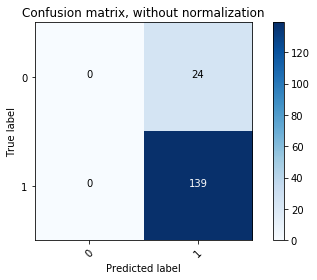

In [25]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


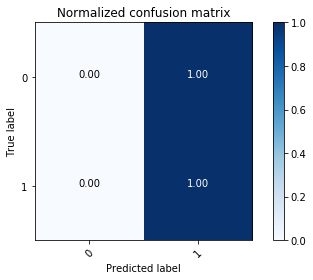

In [26]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

In [27]:
from sklearn.metrics import classification_report
print(classification_report(test[y_column], y_pred))  

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        24
          1       0.85      1.00      0.92       139

avg / total       0.73      0.85      0.78       163



C:\Users\sara\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
from  sklearn.metrics import accuracy_score
accu = accuracy_score(test[y_column], y_pred)
accu

0.852760736196319